In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from abc import ABC, abstractmethod
from scipy.integrate import solve_ivp
from scipy import fftpack
from sklearn.metrics import mean_squared_error
from fractions import Fraction

In [6]:
def plot_time_series(data_dict: dict, t_span: np.ndarray, axis_labels: tuple, title: str, size: tuple = (20, 6)):
    """
    Plots a time series graph for the given data.

    Parameters:
    data_dict (dict): A dictionary where keys are labels and values are data arrays to be plotted.
    t_span (np.ndarray): An array representing the time span for the x-axis.
    axis_labels (tuple): A tuple containing the x-axis and y-axis labels as strings.
    title (str): The title of the plot.
    size (tuple, optional): A tuple representing the size of the plot (width, height). Default is (20, 6).

    Returns:
    None
    """
    
    width, height = size
    fig, ax = plt.subplots(figsize=(width, height))

    for label, data in data_dict.items():
        ax.plot(t_span, data, label=label)

    x_label, y_label = axis_labels
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.legend()
    ax.grid()

    plt.show()

In [ ]:
class EpidemiologyModel(ABC):
    """
    Abstract class for epidemiology models.
    """
    
    def __init__(self, beta: float, gamma: float, population: int, initial_infected: int):
        """
        Initializes the epidemiology model.

        Parameters:
        beta (float): The infection rate.
        gamma (float): The recovery rate.
        population (int): The total population.
        initial_infected (int): The initial number of infected individuals.

        Returns:
        None
        """

        self.beta = beta
        self.gamma = gamma
        self.population = population
        self.initial_infected = initial_infected

    @abstractmethod
    def model(self, t: float, y: np.ndarray) -> np.ndarray:
        """
        The model function to be implemented by subclasses.

        Parameters:
        t (float): The time.
        y (np.ndarray): The state vector.

        Returns:
        np.ndarray: The derivative of the state vector.
        """

        pass

    @abstractmethod
    def get_R0(self) -> float:
        """
        Calculates the basic reproduction number.

        Returns:
        float: The basic reproduction number.
        """

        pass

    def solve(self, t_span: tuple, y0: np.ndarray, **kwargs) -> np.ndarray:
        """
        Solves the model using the given initial conditions.

        Parameters:
        t_span (tuple): A tuple containing the initial and final times.
        y0 (np.ndarray): The initial conditions.

        Returns:
        np.ndarray: The solution of the model.
        """

        return solve_ivp(self.model, t_span, y0, **kwargs)
        

In [15]:
class SIR(EpidemiologyModel):
    """
    SIR epidemiology model.
    """

    def model(self, t: float, y: np.ndarray) -> np.ndarray:
        """
        The SIR model function.

        Parameters:
        t (float): The time.
        y (np.ndarray): The state vector.

        Returns:
        np.ndarray: The derivative of the state vector.
        """

        S, I, R = y
        dSdt = -self.beta * S * I / self.population
        dIdt = self.beta * S * I / self.population - self.gamma * I
        dRdt = self.gamma * I

        return np.array([dSdt, dIdt, dRdt])

    def get_R0(self) -> float:
        """
        Calculates the basic reproduction number.

        Returns:
        float: The basic reproduction number.
        """

        return self.beta / self.gamma

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [  0   1 ... 158 159]
        y: [[ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
            [ 1.000e-03  9.048e-04 ...  3.140e-07  3.100e-07]
            [ 0.000e+00  9.516e-05 ...  9.997e-04  9.997e-04]]
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x7f60c7979100>
 t_events: None
 y_events: None
     nfev: 62
     njev: 0
      nlu: 0


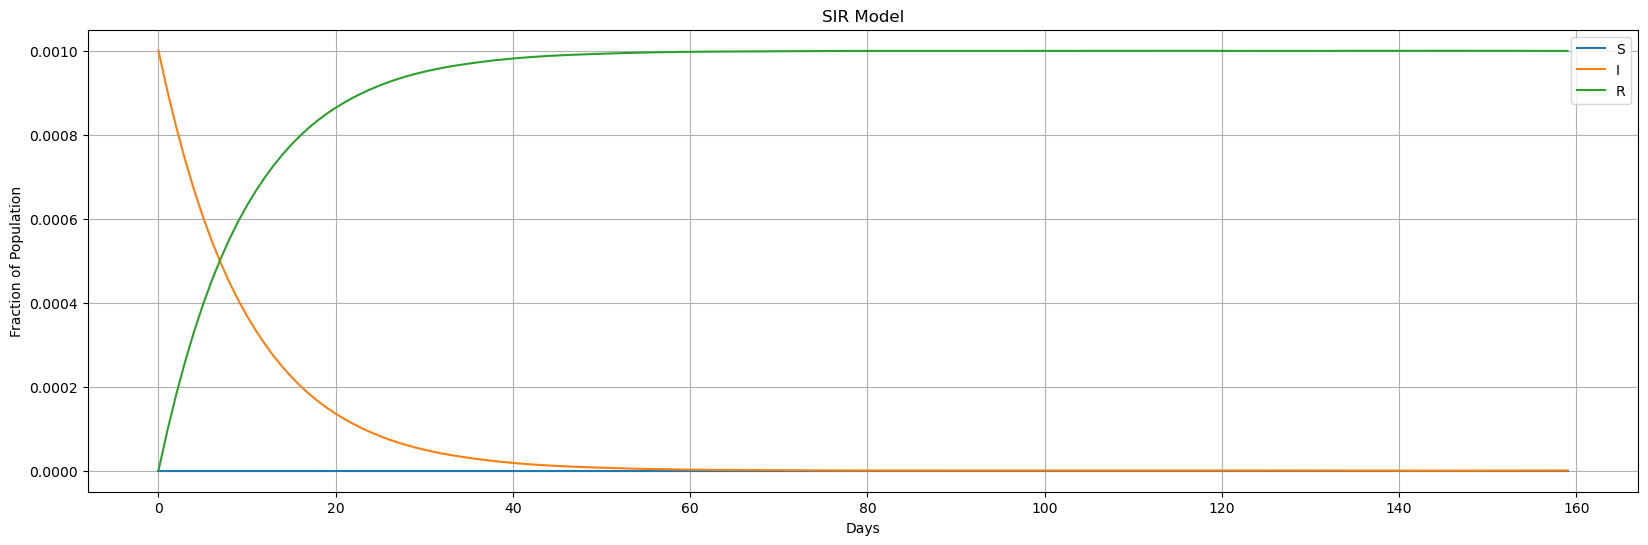

In [18]:
sir = SIR(0.3, 0.1, 1000, 1, 0, 160)
solution = sir.solve()
plot_time_series({"S": solution[0], "I": solution[1], "R": solution[2]}, sir.t_span, ("Days", "Fraction of Population"), "SIR Model")

-------

In [89]:
import numpy as np
from scipy.integrate import solve_ivp


class EpidemiologyModel:
    def __init__(self, initial_conditions, parameters, t, steps=None):
        self.initial_conditions = initial_conditions
        self.parameters = parameters
        self.t = t
        
        if steps == None:
            self.t_eval = np.linspace(0, t, t)
        else:
            self.t_eval = np.linspace(0, t, steps)

    def solve(self, equations):
        sol = solve_ivp(
            fun=equations,
            t_span=[0, self.t],
            y0=self.initial_conditions,
            args=self.parameters,
            t_eval=self.t_eval,
            dense_output=True
        )        
        return sol.sol(self.t_eval)

In [90]:
def sir_equations(t, y, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I
    dIdt = beta * S * I - gamma * I
    dRdt = gamma * I
    return [dSdt, dIdt, dRdt]

def sirv_equations(t, y, beta, gamma, nu):
    S, I, R, V = y
    dSdt = -beta * S * I - nu * S
    dIdt = beta * S * I - gamma * I
    dRdt = gamma * I
    dVdt = nu * S
    return [dSdt, dIdt, dRdt, dVdt]

def seir_equations(t, y, beta, gamma, sigma):
    S, E, I, R = y
    dSdt = -beta * S * I
    dEdt = beta * S * I - sigma * E
    dIdt = sigma * E - gamma * I
    dRdt = gamma * I
    return [dSdt, dEdt, dIdt, dRdt]


In [91]:
# Common parameters
t = 160
initial_conditions_sir = [0.99, 0.01, 0]  # S, I, R for SIR
initial_conditions_sirv = [0.99, 0.01, 0, 0]  # S, I, R, V for SIRV
initial_conditions_seir = [0.99, 0.0, 0.01, 0]  # S, E, I, R for SEIR

# Parameters for each model
params_sir = (0.3, 0.1)  # beta, gamma for SIR
params_sirv = (0.3, 0.1, 0.01)  # beta, gamma, nu for SIRV
params_seir = (0.3, 0.2, 0.1)  # beta, sigma, gamma for SEIR

# Solve SIR
sir_model = EpidemiologyModel(initial_conditions_sir, params_sir, t)
solution_sir = sir_model.solve(sir_equations)

# Solve SIRV
sirv_model = EpidemiologyModel(initial_conditions_sirv, params_sirv, t)
solution_sirv = sirv_model.solve(sirv_equations)

# Solve SEIR
seir_model = EpidemiologyModel(initial_conditions_seir, params_seir, t)
solution_seir = seir_model.solve(seir_equations)


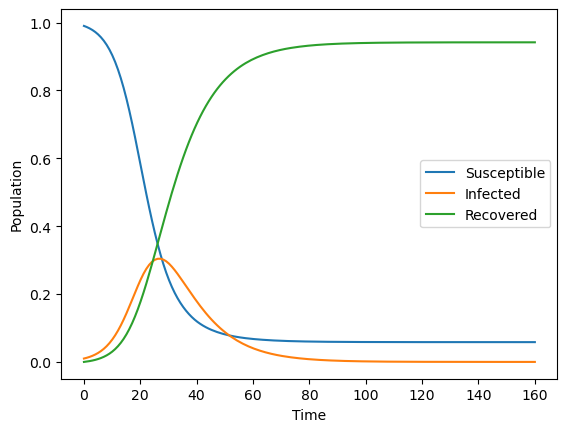

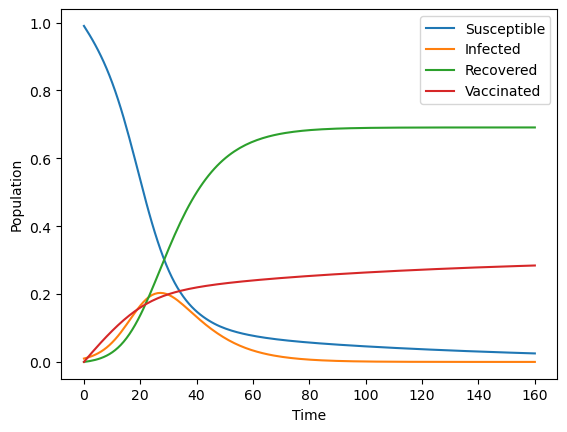

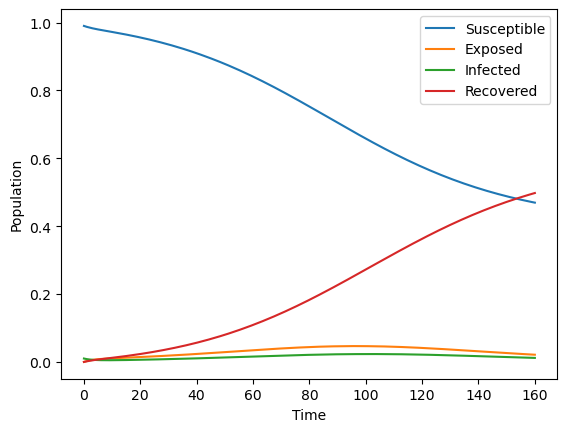

In [107]:
import matplotlib.pyplot as plt

def plot_solution(t, solution, labels):
    t = np.linspace(0, t, len(solution[0]))
    for i, label in enumerate(labels):
        plt.plot(t, solution[i], label=label)
    plt.xlabel('Time')
    plt.ylabel('Population')
    plt.legend()
    plt.show()

# Plot SIR
plot_solution(t, solution_sir, ['Susceptible', 'Infected', 'Recovered'])

# Plot SIRV
plot_solution(t, solution_sirv, ['Susceptible', 'Infected', 'Recovered', 'Vaccinated'])

# Plot SEIR
plot_solution(t, solution_seir, ['Susceptible', 'Exposed', 'Infected', 'Recovered'])
